# Lokaverkefni TÖL403G 2025

## Höfundar
Sigurður Ari Stefánsson

Svava Þóra Árnadóttir

## imports

In [430]:
import pandas as pd
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time
from math import sqrt


# Liður 2.3.1 (*) 

### Þáttun

Lesið inn netið úr skránum sem eru gefnar, nodes.tsv og edges.tsv. Í skránni nodes.tsv
eru hnútar með auðkenni (id), hnit (x, y) og hvort þeir séu á aðalvegi (primary). Í skránni
edges.tsv eru leggi frá hnúti u til hnúts v með lengd length, mæld í metrum, og nafn
(name).

In [431]:
# Lesa og hreinsa gögn 
nodes_df = pd.read_csv('nodes.tsv', sep='\t', header=0, names=['id', 'x', 'y', 'primary'])
edges_df = pd.read_csv('edges.tsv', sep='\t', header=0, names=['u', 'v', 'length', 'name'])

nodes_df = nodes_df[nodes_df['id'] != 'osmid']
edges_df = edges_df[edges_df['u'] != 'u']

nodes_df['id'] = nodes_df['id'].astype(int)
nodes_df['x'] = nodes_df['x'].astype(float)
nodes_df['y'] = nodes_df['y'].astype(float)
nodes_df['primary'] = nodes_df['primary'].astype(bool)

edges_df['u'] = edges_df['u'].astype(int)
edges_df['v'] = edges_df['v'].astype(int)
edges_df['length'] = edges_df['length'].astype(float)


# Liður 2.3.2 (**)

### Leit

Ef við setjum hleðslustöðvar á hnúta v1, . . . , vk þá er hægt að nota reikniritið dijkstra til að
finna stystu fjarlægð frá hnverjum hnúti u í hleðslustöð vi. Útfærið reikniritið sem tekur
inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. Athugið að netið
er stefnt net.

In [432]:
# Multi-source Dijkstra: reiknar stystu leið í einhverja hleðslustöð
def dijkstra_to_charging(graph, charging_nodes):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    reversed_graph = defaultdict(list)

    # snúa netinu við til þess að reikna vegalengd frá hnút að stöð
    for u in graph:
        for v, weight in graph[u]:
            reversed_graph[v].append((u, weight))

    # Upphafsstilla fjarlægðir á hleðslustöðvum sem 0 og setja á heap. 
    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    visited_count = 0
        
    # Leit
    while heap:
        current_dist, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        visited_count += 1

        for v, weight in reversed_graph[u]:
            if dist[v] > current_dist + weight:
                dist[v] = current_dist + weight
                heapq.heappush(heap, (dist[v], v))

    #print(f"Dijkstra visited {visited_count} nodes.")
    return dist


In [433]:
# breytir punkt í google maps link
gmaps_urls = {}
for _, row in nodes_df.iterrows():
    gmaps_urls[row['id']] = f"https://www.google.com/maps?q={row['y']},{row['x']}"

print(gmaps_urls[12885922])

https://www.google.com/maps?q=64.0319775,-22.0878904


# Liður 2.3.3 (*)

### Framsetning

Setjið fimm hleðslustöðvar í netið og sýnið stystu leið fyrir fimm punkta og teiknið upp á
kort. Tékkið ykkur af með því að bera saman leiðina sem er fundin og fjarlægðina miðað
við kortavefi eins og t.d. Google Maps.

Distance to station for node 1186616568: 1061.9433348008124m
Distance to station for node 241784654: 3539.156663593519m
Distance to station for node 11641311433: 9879.794632032172m
Distance to station for node 11137114625: 1436.7909221999978m
Distance to station for node 253469037: 4346.811123446911m


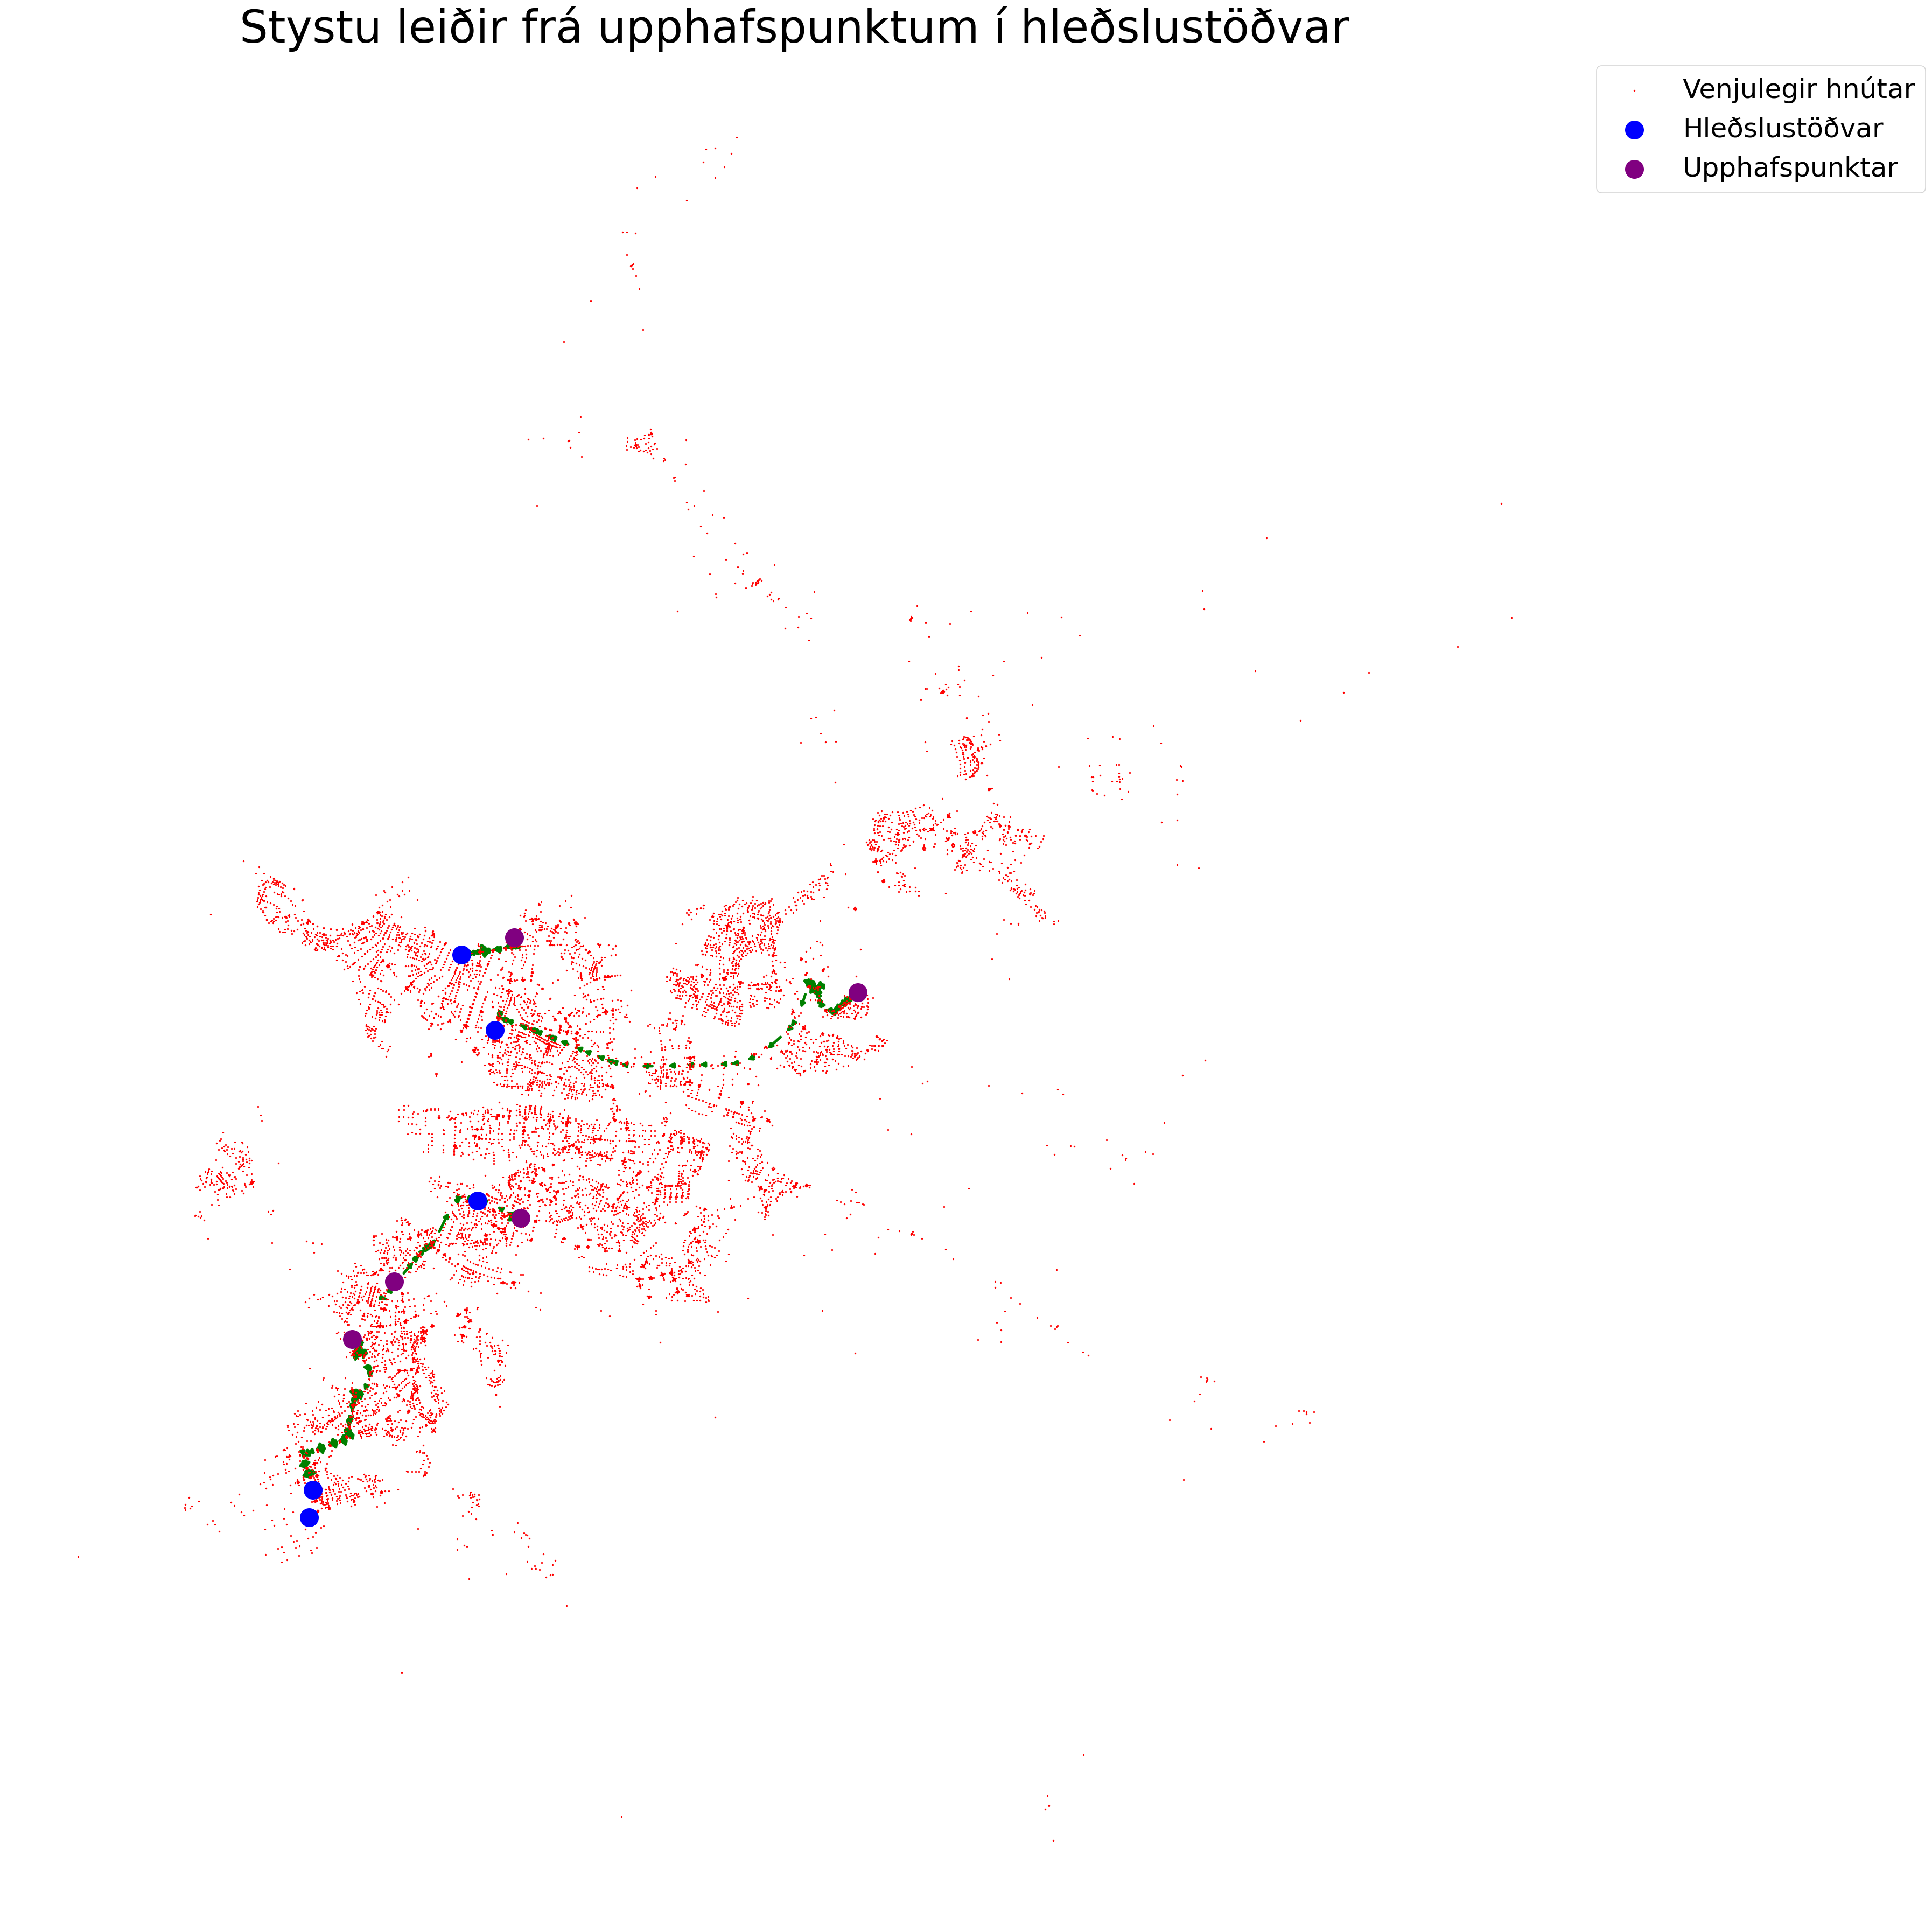

Start Node:  1186616568
https://www.google.com/maps?q=64.0955512,-21.8883475
Start Node:  241784654
https://www.google.com/maps?q=64.0835592,-21.9453247
Start Node:  11641311433
https://www.google.com/maps?q=64.1378368,-21.7361517
Start Node:  11137114625
https://www.google.com/maps?q=64.1481539,-21.8911121
Start Node:  253469037
https://www.google.com/maps?q=64.072827,-21.9643267
Charging Node:  26481023
https://www.google.com/maps?q=64.1449961,-21.914858
Charging Node:  2325888359
https://www.google.com/maps?q=64.1307609,-21.8999934
Charging Node:  5098498898
https://www.google.com/maps?q=64.0393631,-21.9836985
Charging Node:  599332607
https://www.google.com/maps?q=64.0444857,-21.9820114
Charging Node:  297899459
https://www.google.com/maps?q=64.0987287,-21.9076808


In [434]:
# 1. Búa til stefnt net: u -> listi af (v, length)
graph = defaultdict(list)
for _, row in edges_df.iterrows():
    graph[row['u']].append((row['v'], row['length']))


# 2. Finna hvaða hnútar eru hleðslustöðvar (primary == True)
all_charging_stations = nodes_df[nodes_df['primary'] == True]['id'].tolist()

# 3. Velja 5 random hleðslustöðvar með seedi.
random.seed(420)

charging_station_nodes = random.sample(all_charging_stations, 5)


# 4. Velja 5 random upphafshnúta sem EKKI eru hleðslustöðvar
non_stations = nodes_df[~nodes_df['id'].isin(charging_station_nodes)]
start_nodes = random.sample(non_stations['id'].tolist(), 5)

# 5. Reikna stystu vegalengdir að næstu hleðslustöð
shortest_to_station = dijkstra_to_charging(graph, charging_station_nodes)

# 6. Setja niðurstöðurnar í DataFrame
distances_df = pd.DataFrame([
    {'id': node_id, 'distance_to_station': shortest_to_station[node_id]}
    for node_id in nodes_df['id']
])

# 7. Birta hnútana sem eru valdir
for node in start_nodes:
    distance = distances_df.loc[distances_df['id'] == node, 'distance_to_station'].values
    print(f"Distance to station for node {node}: {distance[0]}m")


# 8. Leitarfall: Dijkstra leið frá einum hnút í næstu stöð til að teikna
def dijkstra_path(graph, source, targets):
    dist = {node: float('inf') for node in nodes_df['id']}
    prev = {}
    heap = [(0, source)]
    dist[source] = 0
    while heap:
        d, u = heapq.heappop(heap)
        if u in targets:
            break
        for v, w in graph[u]:
            if dist[v] > d + w:
                dist[v] = d + w
                prev[v] = u
                heapq.heappush(heap, (dist[v], v))
    found = min([(t, dist[t]) for t in targets if dist[t] < float('inf')], key=lambda x: x[1], default=(None, None))
    if found[0] is None:
        return []
    path = []
    current = found[0]
    while current != source:
        path.append(current)
        current = prev[current]
    path.append(source)
    return list(reversed(path))

# 9. Teikna netið 
G = nx.DiGraph()

## notað í A* líka
node_positions = {}

for _, row in nodes_df.iterrows():
    node_id = row['id']
    node_positions[node_id] = (row['x'], row['y'])
    G.add_node(node_id)
for _, row in edges_df.iterrows():
    G.add_edge(row['u'], row['v'], length=row['length'])

plt.figure(figsize=(30, 30), dpi=120)

# 9.1. Venjulegir hnútar
non_charging_nodes = [n for n in G.nodes if n not in charging_station_nodes]
nx.draw_networkx_nodes(G, node_positions, nodelist=non_charging_nodes, node_color='red', node_size=1, label='Venjulegir hnútar')

# 9.2. Hleðslustöðvar
nx.draw_networkx_nodes(G, node_positions, nodelist=charging_station_nodes, node_color='blue', node_size=400, label='Hleðslustöðvar')

# 9.3. Upphafshnútar
nx.draw_networkx_nodes(G, node_positions, nodelist=start_nodes, node_color='purple', node_size=400, label='Upphafspunktar')

# 9.4. Leggir
#nx.draw_networkx_edges(G, node_positions, alpha=0.3, arrows=True, arrowstyle='-|>', arrowsize=8, width=0.3)

# 9.5. Teikna stystu leiðir
for start in start_nodes:
    path = dijkstra_path(graph, start, charging_station_nodes)
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='green', width=3)

plt.title("Stystu leiðir frá upphafspunktum í hleðslustöðvar", fontsize=50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
plt.axis('off')
plt.tight_layout()
plt.show()

for v in start_nodes:
    print('Start Node: ', v)
    print(gmaps_urls[v])

for v in charging_station_nodes:
    print('Charging Node: ', v)
    print(gmaps_urls[v])


In [435]:
shortest_to_station[9207425915]

1618.0305930408974

# Liður 2.3.4 (*)

### Tímamælingar

Mælið tímann sem reikniritið dijkstra tekur að reikna allar fjarlægðir í netinu með fimm
hleðslustöðvum.

In [436]:
start_time = time.time()
shortest_to_station_time = dijkstra_to_charging(graph, charging_station_nodes)
end_time = time.time()

total_time = end_time - start_time

print(f"Tími fyrir Dijkstra fyrir allla punkta í 5 hleðslustöðvar: {total_time:.4f} sek")

Tími fyrir Dijkstra fyrir allla punkta í 5 hleðslustöðvar: 0.0168 sek


# Liður 2.3.5 (**)

### A* reikniritið

Útfærið A⋆ reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öll-
um hnútum í netinu. Sem neðra mat á fjarlægð á milli hnútanna má taka $d(u, v) = \sqrt{(x_u − x_v )^2 + (y_u − y_v )^2}$, þ.e. beina loftlínu milli punktanna. Mælið tíma og berið saman
við reiknirit Dijkstra.

In [437]:
# Útgáfa Sigga
def lower_estimate(node_id, charging_stations, pos):
    x1, y1 = pos[node_id]
    return min(
        sqrt((x1 - pos[station][0])**2 + (y1 - pos[station][1])**2)
        for station in charging_stations
    )

# A*: reiknar stystu leið í einhverja hleðslustöð
# tekur inn net, hleðslustöðvar/target nodes og staðsetningar (x, y) upplýsingar um hvern hnút.  
def a_star_to_charging(graph, charging_nodes, pos):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    # snúa netinu við, til að reikna frá hverjum hnút að stöð
    reversed_graph = defaultdict(list)
    for u in graph:
        for v, weight in graph[u]:
            reversed_graph[v].append((u, weight))
            
    # Upphafsstilla fjarlægðir á hleðslustöðvum sem 0 og setja á heap. 
    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    visited_count = 0
        
    # Leit
    while heap:
        _, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        visited_count += 1

        for v, weight in reversed_graph[u]:
            d = dist[u] + weight
            if d < dist[v]:
                dist[v] = d
                euc = lower_estimate(v, charging_nodes, pos)
                heapq.heappush(heap, (d + euc, v))

    #print(f"A* visited {visited_count} nodes.")
    return dist


# Keyrir á sama tíma og dijkstra því þau leita á svipaðann hátt því euc distance er ekki nógu stórt til að hafa áhrif
# gætum prufað að setja hleðslustöðvar út í öll horn eða eh og sjá hvort það kemur munur 
start_time = time.time()
a_star = a_star_to_charging(graph, charging_station_nodes, node_positions)
end_time = time.time()

total_time = end_time - start_time
print(f"Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar {total_time:.4f} sek")

Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar 0.0923 sek


In [438]:
# Útgáfa Svövu
import math
import heapq

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def a_star_to_targets(graph, nodes_df, goal_nodes):
    # 1. Positions of all nodes (for heuristic)
    positions = nodes_df.set_index('id')[['x', 'y']].to_dict('index')

    # 2. Initialize distances and priority queue
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    for goal in goal_nodes:
        dist[goal] = 0
        heapq.heappush(heap, (0, goal))  # (f = g + h, node)

    while heap:
        f, current = heapq.heappop(heap)
        if current in visited:
            continue
        visited.add(current)

        x_curr, y_curr = positions[current]['x'], positions[current]['y']

        for neighbor, weight in graph[current]:
            if neighbor in visited:
                continue

            g = dist[current] + weight
            x_neigh, y_neigh = positions[neighbor]['x'], positions[neighbor]['y']

            # Heuristic: min distance to any goal node (since multi-goal)
            h = min([
                euclidean_distance(x_neigh, y_neigh, positions[goal]['x'], positions[goal]['y'])
                for goal in goal_nodes
            ])

            f = g + h

            if g < dist[neighbor]:
                dist[neighbor] = g
                heapq.heappush(heap, (f, neighbor))

    return dist  # dictionary: node_id → distance to nearest goal


start_time = time.time()
a_star = a_star_to_targets(graph, nodes_df, charging_station_nodes)
end_time = time.time()

total_time = end_time - start_time
print(f"Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar {total_time:.4f} sek")

Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar 0.0456 sek


# Liður 2.3.6 (**)

### Staðsetning hleðslustöðva

Ef við setjum k hleðslustöðvar í hnúta $v_1, . . . , v_k$ þá látum við markfallið vera

$$F(v_1,...,v_k) = \sum_{u \in V} \underset{i=1,...,k}{min} d(u,v_i)$$

þ.e. fyrir hvern hnút í netinu reiknum við stystu fjarlægð frá honum til næstu hleðslustöðvar
og leggjum saman yfir alla hnúta í netinu.

Finnið bestu lausn fyrir k = 1, með því að prófa alla hnúta sem hægt er að setja
hleðslustöð í og veljið þann sem gefur minnsta markfall. Athugið að eingöngu þeir hnútar
sem eru merktir sem primary geta verið hleðslustöðvar.

In [439]:
best_station = None
mark = float('inf')
count = 0

for station in all_charging_stations:
    distances = dijkstra_to_charging(graph, [station])

    total = 0

    for node_id in distances:
        if distances[node_id] == float('inf'):
            # Bæta við stórri tölu ef dist er inf eins og í hnút 5541083892, bæti við 50km
            total += 50000
        else:
            total += distances[node_id]

    #print(f"Stöð {station} hefur markfallið {total}.")
    count += 1

    if total < mark:
        mark = total
        best_station = station
    #print(f"Minnsta markfallið hingað til er {mark} frá stöð {best_station}.")


print(f"Besta hleðslustöðin er {best_station} með markfallið  {mark}.")
print(f"Fjöldi athugaðra hleðslustöðva er {count}")
    

Besta hleðslustöðin er 34827739 með markfallið  72442102.57913065.
Fjöldi athugaðra hleðslustöðva er 1829


# Liður 2.3.7 (**)

### Gráðug reiknirit

Útfærið gráðugt reiknirit sem leitar að bestu lausn fyrir $k = 2, . . . , 10$ með því að leysa
vandamálið fyrir k−1 hleðslustöðvum og bæta þá við þann hnút sem gefur minnsta markfall,
miðað við að ekki sé hægt að breyta $v_1, . . . , v_{k−1}$
Sýnið á korti hvaða hleðslustöðvar eru valdar fyrir k = 10 og mælið tímann sem reikniritið
tekur.

# Liður 2.3.8 (**)

### Skárri gráðug reiknirit

Gráðuga reikniritið á það til að mála sig út í horn með því að velja lélegan fyrsta hnút.
Breytið leitinni þannig að þið veljið handahófskenndan fyrsta hnút og farið endurkvæmt í
tilfellin $k = 2, . . . , 10.$ Í hverju undirtilfelli finnið þið 2 bestu hnútana sem koma til greina
en eru langt frá hvor öðrum og prófið endurkvæmt alla möguleika. Haldið utan um bestu
lausnina sem finnst fyrir nokkur hanndahófskennda upphafspunkta og sýnið bestu lausn á
korti. Hve mikinn tíma tekur reikniritið ykkar?

# Liður 2.3.9 (***)

### Nákvæm lausn fyrir k=10

Finnið bestu lausn fyrir k = 10 með því að setja vandamálið upp sem heiltölubestunarverk-
efni (e. integer linear program) og leysa það með því að nota pakka á borð við Gurobi eða
OR-tools. Athugið að verkefnið gæti verið of stórt fyrir þessa pakka. Nýtið ykkur götur í
hverfum eru oft teng við primary hnúta í gegnum einn veg, þá er hægt að einfalda netið með
því að skipta þessum hverfum út fyrir einn hnút sem tengir sameiginlegan primary hnút.
Þessa leggi er hægt að finna með DFS. Sýnið bestu lausnina á korti og mælið tímann sem
heiltölubestunarverkefnið tekur.
3
